In [1]:
# ÌôòÍ≤Ω ÏÑ§Ï†ï
import os
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# GPU ÏÑ§Ï†ï
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDAÎ•º ÏÇ¨Ïö©Ìï† Ïàò ÏóÜÏäµÎãàÎã§. CPU Î™®ÎìúÎ°ú Ïã§ÌñâÎê©ÎãàÎã§.')

# ÏãúÎìú Í≥†Ï†ï Ïú†Ìã∏Î¶¨Ìã∞ Ìï®Ïàò
def seed_everything(seed=42):
    """Î™®Îì† ÎÇúÏàò ÏÉùÏÑ±Í∏∞ ÏãúÎìúÎ•º Í≥†Ï†ïÌïòÎäî Ìï®Ïàò"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"üîí Î™®Îì† ÏãúÎìúÎ•º {seed}Î°ú Í≥†Ï†ïÏôÑÎ£å")

# Ï¥àÍ∏∞ ÏãúÎìú Í≥†Ï†ï
seed_everything(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


# Stage 3 ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò: Îã§ÏñëÌïú ÏúÑÏ°∞ ÎπÑÏú®ÏóêÏÑúÏùò MIL Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù

Ïù¥ ÎÖ∏Ìä∏Î∂ÅÏùÄ Stage 2ÏóêÏÑú ÏÉùÏÑ±Ìïú **Îã§ÏñëÌïú ÏúÑÏ°∞ ÎπÑÏú®**(5%, 10%, 20%, 30%, 50%) MIL Bag Îç∞Ïù¥ÌÑ∞Î•º ÏûÖÎ†•ÏúºÎ°ú Î∞õÏïÑ Î™®Îç∏ ÏÑ±Îä•ÏùÑ ÎπÑÍµê Ïã§ÌóòÌï©ÎãàÎã§.

**Ïã§Ìóò Î™©Ìëú:**
- ÎÇÆÏùÄ ÏúÑÏ°∞ ÎπÑÏú®(5%, 10%)ÏóêÏÑúÏùò Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä
- ÏúÑÏ°∞ ÌÉêÏßÄ Recall Ïú†ÏßÄ Îä•Î†• Î∂ÑÏÑù (ÏúÑÏ°∞Î•º ÎÜìÏπòÏßÄ ÏïäÎäî Îä•Î†•)
- Matched vs Shift Î™®Îìú ÏÑ±Îä• ÎπÑÍµê
- Î™®Îç∏Î≥Ñ ÏúÑÏ°∞ ÎπÑÏú® Ï†ÅÏùëÏÑ± Î∂ÑÏÑù

**Ïã§Ìóò Î™®Îìú:**
1. **Matched Î™®Îìú**: Í∞Å ÎπÑÏú®(5/10/20/30%)Î≥ÑÎ°ú ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú ÌïôÏäµ/ÌèâÍ∞Ä
2. **Shift Î™®Îìú**: 30% ÎπÑÏú®Î°ú ÌïôÏäµ ‚Üí Îã§ÏñëÌïú ÎπÑÏú®(5/10/20/30%)Î°ú ÌèâÍ∞Ä

**ÌèâÍ∞Ä Î™®Îç∏:**
- Basic Attention MIL
- DSMIL (Dual-stream MIL)
- Mean Pooling (Î≤†Ïù¥Ïä§ÎùºÏù∏)

**Ï§ëÏöîÌïú Ïó∞Íµ¨ ÏßàÎ¨∏:**
- ÏúÑÏ°∞ ÎπÑÏú®Ïù¥ ÎÇÆÏïÑÏßàÏàòÎ°ù ÏÑ±Îä•Ïù¥ ÏñºÎßàÎÇò Ï†ÄÌïòÎêòÎäîÍ∞Ä?
- Ïñ¥Îñ§ Î™®Îç∏Ïù¥ ÎÇÆÏùÄ ÏúÑÏ°∞ ÎπÑÏú®ÏóêÏÑú Îçî Í∞ïÍ±¥ÌïúÍ∞Ä?
- 30% ÌïôÏäµ Î™®Îç∏Ïù¥ 5% ÌÖåÏä§Ìä∏ÏóêÏÑúÎèÑ Ïûò ÎèôÏûëÌïòÎäîÍ∞Ä? (ÎèÑÎ©îÏù∏ Ï†ÅÏùë)

In [2]:
# ÏúÑÏ°∞ ÎπÑÏú®Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïú†Ìã∏Î¶¨Ìã∞
def ratio_to_tag(pos_ratio: float) -> str:
    """ÎπÑÏú®ÏùÑ ÌååÏùºÎ™Ö ÌÉúÍ∑∏Î°ú Î≥ÄÌôò: 0.05 ‚Üí '05p', 0.30 ‚Üí '30p'"""
    return f"{int(round(pos_ratio*100)):02d}p"

def load_forgery_data(bags_dir, margin='0.4', ratios=[0.05, 0.10, 0.20, 0.30, 0.50]):
    """Îã§ÏñëÌïú ÏúÑÏ°∞ ÎπÑÏú®Ïùò MIL Bag Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìú"""
    data_dict = {}
    
    print("üìÅ ÏúÑÏ°∞ ÎπÑÏú®Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
    print("=" * 60)
    
    for ratio in ratios:
        rtag = ratio_to_tag(ratio)
        print(f"  Loading {rtag} ({ratio:.0%}) datasets...")
        
        # ÌååÏùº Í≤ΩÎ°ú ÏÉùÏÑ±
        train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_train.pkl')
        val_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_val.pkl')
        test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        
        # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        try:
            with open(train_pkl, 'rb') as f:
                train_data = pickle.load(f)
            with open(val_pkl, 'rb') as f:
                val_data = pickle.load(f)
            with open(test_pkl, 'rb') as f:
                test_data = pickle.load(f)
                
            data_dict[rtag] = {
                'train': train_data,
                'val': val_data,
                'test': test_data,
                'ratio': ratio
            }
            
            print(f"    ‚úÖ {rtag}: Train={len(train_data['labels'])}, Val={len(val_data['labels'])}, Test={len(test_data['labels'])}")
            
        except FileNotFoundError as e:
            print(f"    ‚ùå {rtag}: ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§ - {e}")
            continue
    
    print("=" * 60)
    print(f"‚úÖ Ï¥ù {len(data_dict)}Í∞ú ÎπÑÏú® Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú ÏôÑÎ£å")
    return data_dict

def load_shift_data(bags_dir, margin='0.4', train_ratio=0.30, eval_ratios=[0.05, 0.10, 0.20, 0.30, 0.50]):
    """Shift Î™®ÎìúÏö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú: 30% ÌïôÏäµ + Îã§ÏñëÌïú ÎπÑÏú® ÌèâÍ∞Ä"""
    print("üìÅ Shift Î™®Îìú Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
    print("=" * 60)
    
    # ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ (30%)
    train_rtag = ratio_to_tag(train_ratio)
    train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_train.pkl')
    val_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_val.pkl')
    # Shift Ï†ÑÏö© ÎÑ§ÏûÑÏä§ÌéòÏù¥Ïä§ ÌååÏùºÏù¥ ÏûàÏúºÎ©¥ Ïö∞ÏÑ† ÏÇ¨Ïö©
    train_pkl_shift = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_train_shiftbase.pkl')
    val_pkl_shift   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_val_shiftbase.pkl')
    if os.path.exists(train_pkl_shift):
        train_pkl = train_pkl_shift
    if os.path.exists(val_pkl_shift):
        val_pkl = val_pkl_shift


    
    with open(train_pkl, 'rb') as f:
        train_data = pickle.load(f)
    with open(val_pkl, 'rb') as f:
        val_data = pickle.load(f)
    
    print(f"  ÌïôÏäµÏö© {train_rtag} ({train_ratio:.0%}): Train={len(train_data['labels'])}, Val={len(val_data['labels'])}")
    
    # ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞Îì§
    eval_data = {}
    for ratio in eval_ratios:
        rtag = ratio_to_tag(ratio)
        test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test_shift_{rtag}.pkl')
        
        # Shift ÌèâÍ∞Ä ÌååÏùºÏù¥ ÏóÜÏúºÎ©¥ ÏùºÎ∞ò ÌÖåÏä§Ìä∏ ÌååÏùº ÏÇ¨Ïö©
        if not os.path.exists(test_pkl):
            test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        
        try:
            with open(test_pkl, 'rb') as f:
                test_data = pickle.load(f)
            eval_data[rtag] = {
                'test': test_data,
                'ratio': ratio
            }
            print(f"  ÌèâÍ∞ÄÏö© {rtag} ({ratio:.0%}): Test={len(test_data['labels'])}")
        except FileNotFoundError:
            print(f"  ‚ùå {rtag}: ÌèâÍ∞Ä ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§")
    
    print("=" * 60)
    print(f"‚úÖ Shift Î™®Îìú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: ÌïôÏäµ {train_rtag} + ÌèâÍ∞Ä {len(eval_data)}Í∞ú")
    
    return {
        'train': train_data,
        'val': val_data,
        'eval_sets': eval_data,
        'train_ratio': train_ratio
    }

print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïú†Ìã∏Î¶¨Ìã∞ Ï†ïÏùò ÏôÑÎ£å")

‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïú†Ìã∏Î¶¨Ìã∞ Ï†ïÏùò ÏôÑÎ£å


In [3]:
# ÏúÑÏ°∞ ÎπÑÏú®Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
RATIOS = [0.05, 0.10, 0.20, 0.30, 0.50]

# Matched Î™®ÎìúÏö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú
matched_data = load_forgery_data(bags_dir, embedding_margin, RATIOS)

# Shift Î™®ÎìúÏö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú
shift_data = load_shift_data(bags_dir, embedding_margin, train_ratio=0.30, eval_ratios=RATIOS)

# Instance mean Í≥ÑÏÇ∞ Ìï®Ïàò: (10,5,256) ‚Üí (10,256)
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

print("\nüîÑ Instance mean Í≥ÑÏÇ∞ Ï§ë...")
# Matched Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
for rtag, data in matched_data.items():
    data['train_features'] = to_instance_means(data['train']['bags'])
    data['val_features'] = to_instance_means(data['val']['bags'])
    data['test_features'] = to_instance_means(data['test']['bags'])
    
# Shift Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
shift_data['train_features'] = to_instance_means(shift_data['train']['bags'])
shift_data['val_features'] = to_instance_means(shift_data['val']['bags'])
for rtag, eval_set in shift_data['eval_sets'].items():
    eval_set['test_features'] = to_instance_means(eval_set['test']['bags'])

print("‚úÖ Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å")

üìÅ ÏúÑÏ°∞ ÎπÑÏú®Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
  Loading 05p (5%) datasets...
    ‚úÖ 05p: Train=3600, Val=1200, Test=1200
  Loading 10p (10%) datasets...
    ‚úÖ 10p: Train=3600, Val=1200, Test=1200
  Loading 20p (20%) datasets...
    ‚úÖ 20p: Train=3600, Val=1200, Test=1200
  Loading 30p (30%) datasets...
    ‚úÖ 30p: Train=3600, Val=1200, Test=1200
  Loading 50p (50%) datasets...
    ‚úÖ 50p: Train=3600, Val=1200, Test=1200
‚úÖ Ï¥ù 5Í∞ú ÎπÑÏú® Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú ÏôÑÎ£å
üìÅ Shift Î™®Îìú Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
  ÌïôÏäµÏö© 30p (30%): Train=3600, Val=1200
  ÌèâÍ∞ÄÏö© 05p (5%): Test=1200
  ÌèâÍ∞ÄÏö© 10p (10%): Test=1200
  ÌèâÍ∞ÄÏö© 20p (20%): Test=1200
  ÌèâÍ∞ÄÏö© 30p (30%): Test=1200
  ÌèâÍ∞ÄÏö© 50p (50%): Test=1200
‚úÖ Shift Î™®Îìú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: ÌïôÏäµ 30p + ÌèâÍ∞Ä 5Í∞ú

üîÑ Instance mean Í≥ÑÏÇ∞ Ï§ë...
‚úÖ Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å


In [4]:
# Dataset ÌÅ¥ÎûòÏä§ (on‚Äëthe‚Äëfly Tensor Î≥ÄÌôò)
class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features  # list of np.ndarray
        self.labels = labels      # list of int
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

def create_dataloaders(features, labels, batch_size=16):
    """FeaturesÏôÄ labelsÎ°úÎ∂ÄÌÑ∞ DataLoader ÏÉùÏÑ±"""
    train_loader = DataLoader(MILDataset(features['train'], labels['train']), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(MILDataset(features['val'], labels['val']), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(MILDataset(features['test'], labels['test']), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

print("‚úÖ Dataset ÌÅ¥ÎûòÏä§ Î∞è DataLoader Ïú†Ìã∏Î¶¨Ìã∞ Ï†ïÏùò ÏôÑÎ£å")

‚úÖ Dataset ÌÅ¥ÎûòÏä§ Î∞è DataLoader Ïú†Ìã∏Î¶¨Ìã∞ Ï†ïÏùò ÏôÑÎ£å


In [5]:
# WeightedBCE ÏÜêÏã§Ìï®Ïàò Ï†ïÏùò
class WeightedBCE(nn.Module):
    """Weighted Binary Cross Entropy Loss - False PositiveÏóê Îçî ÌÅ∞ Í∞ÄÏ§ëÏπò Î∂ÄÏó¨"""
    def __init__(self, fp_weight=2.0):
        super().__init__()
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        # False Positive (label=0Ïù∏Îç∞ ÏòàÏ∏°Ïù¥ 1)Ïóê Îçî ÌÅ∞ Í∞ÄÏ§ëÏπò
        fp_mask = (labels == 0).float()
        loss = loss * (1 + self.fp_weight * fp_mask)
        return loss.mean()

print("‚úÖ WeightedBCE ÏÜêÏã§Ìï®Ïàò ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å")
print(f"   FP Weight: 2.0 (baselineÍ≥º ÎèôÏùº)")

‚úÖ WeightedBCE ÏÜêÏã§Ìï®Ïàò ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å
   FP Weight: 2.0 (baselineÍ≥º ÎèôÏùº)


In [6]:
# MIL Î™®Îç∏ Ï†ïÏùò: Attention vs DSMIL vs Mean Pooling

class AttentionMIL(nn.Module):
    """Í∏∞Î≥∏ Attention-based MIL Î™®Îç∏"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Attention mechanism
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    
    def _init_weights(self):
        # He initialization for ReLU layers
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        # Xavier for others
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        # Instance feature transformation: (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        # Attention calculation
        a = torch.tanh(self.att_fc1(h))  # (B, N, hidden_dim)
        a = self.att_fc2(a).squeeze(-1)  # (B, N)
        weights = torch.softmax(a, dim=1)  # (B, N)
        
        # Weighted aggregation
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)  # (B, hidden_dim)
        bag_repr = self.dropout(bag_repr)
        
        # Classification
        logits = self.classifier(bag_repr).squeeze(-1)  # (B,)
        return logits, weights

class DSMILModel(nn.Module):
    """DSMIL (Dual-stream MIL) Î™®Îç∏ - Îëê Í∞úÏùò ÎèÖÎ¶ΩÏ†ÅÏù∏ Ïä§Ìä∏Î¶ºÏúºÎ°ú Íµ¨ÏÑ±"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Í≥µÌÜµ Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Stream 1: Attention Í∏∞Î∞ò Ïä§Ìä∏Î¶º
        self.attention_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.attention_fc2 = nn.Linear(hidden_dim, 1)
        
        # Stream 2: Max pooling Í∏∞Î∞ò Ïä§Ìä∏Î¶º
        self.max_pool_fc = nn.Linear(hidden_dim, hidden_dim)
        
        # Îëê Ïä§Ìä∏Î¶ºÏùÑ Í≤∞Ìï©ÌïòÎäî Î∂ÑÎ•òÍ∏∞
        self.classifier = nn.Linear(hidden_dim * 2, 1)  # Îëê Ïä§Ìä∏Î¶º concat
        self._init_weights()
    
    def _init_weights(self):
        # He initialization for ReLU layers
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        
        # Xavier for attention stream
        nn.init.xavier_uniform_(self.attention_fc1.weight)
        nn.init.zeros_(self.attention_fc1.bias)
        nn.init.xavier_uniform_(self.attention_fc2.weight)
        nn.init.zeros_(self.attention_fc2.bias)
        
        # Xavier for max pooling stream
        nn.init.xavier_uniform_(self.max_pool_fc.weight)
        nn.init.zeros_(self.max_pool_fc.bias)
        
        # Classifier
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        # Í≥µÌÜµ Instance feature transformation: (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        # Stream 1: Attention-based aggregation
        attention_scores = torch.tanh(self.attention_fc1(h))  # (B, N, hidden_dim)
        attention_weights = self.attention_fc2(attention_scores)  # (B, N, 1)
        attention_weights = torch.softmax(attention_weights.squeeze(-1), dim=1)  # (B, N)
        
        # Weighted aggregation for stream 1
        stream1_repr = torch.sum(attention_weights.unsqueeze(-1) * h, dim=1)  # (B, hidden_dim)
        
        # Stream 2: Max pooling based aggregation
        stream2_features = torch.relu(self.max_pool_fc(h))  # (B, N, hidden_dim)
        stream2_repr = torch.max(stream2_features, dim=1)[0]  # (B, hidden_dim)
        
        # Îëê Ïä§Ìä∏Î¶º Í≤∞Ìï©
        combined_repr = torch.cat([stream1_repr, stream2_repr], dim=1)  # (B, hidden_dim*2)
        combined_repr = self.dropout(combined_repr)
        
        # ÏµúÏ¢Ö Î∂ÑÎ•ò
        logits = self.classifier(combined_repr).squeeze(-1)  # (B,)
        
        return logits, attention_weights

class MeanPoolingModel(nn.Module):
    """Î≤†Ïù¥Ïä§ÎùºÏù∏: Îã®Ïàú ÌèâÍ∑† ÌíÄÎßÅ Î™®Îç∏"""
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        bag_mean = x.mean(dim=1)  # (B, input_dim)
        logits = self.fc(bag_mean).squeeze(-1)  # (B,)
        return logits

print("‚úÖ Î™®Îç∏ ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å:")
print("  - AttentionMIL: Í∏∞Î≥∏ attention mechanism")
print("  - DSMILModel: Dual-stream MIL (Attention + Max pooling)")
print("  - MeanPoolingModel: Î≤†Ïù¥Ïä§ÎùºÏù∏ (Îã®Ïàú ÌèâÍ∑†)")

‚úÖ Î™®Îç∏ ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏôÑÎ£å:
  - AttentionMIL: Í∏∞Î≥∏ attention mechanism
  - DSMILModel: Dual-stream MIL (Attention + Max pooling)
  - MeanPoolingModel: Î≤†Ïù¥Ïä§ÎùºÏù∏ (Îã®Ïàú ÌèâÍ∑†)


In [7]:
# Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä Ìï®Ïàò
from sklearn.metrics import precision_score, recall_score

def is_attention_model(model):
    """Attention Í∏∞Î∞ò Î™®Îç∏Ïù∏ÏßÄ ÌôïÏù∏ (AttentionMIL, DSMILModel)"""
    return isinstance(model, (AttentionMIL, DSMILModel))

def train_one_epoch(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        if is_attention_model(model):
            logits, _ = model(X)
        else:
            logits = model(X)
            
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    attention_weights_all = []
    
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            if is_attention_model(model):
                logits, attention_weights = model(X)
                attention_weights_all.append(attention_weights.cpu().numpy())
            else:
                logits = model(X)
                
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            
            probs_all.extend(probs.cpu().numpy())
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    
    # Calculate metrics
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1 = f1_score(labels_all, preds_all, zero_division=0.0)
    precision = precision_score(labels_all, preds_all, zero_division=0.0)
    recall = recall_score(labels_all, preds_all, zero_division=0.0)
    
    # Combine attention weights if available
    attention_weights_combined = np.concatenate(attention_weights_all, axis=0) if attention_weights_all else None
    
    return {
        'loss': total_loss / len(loader.dataset),
        'accuracy': acc,
        'auc': auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'probs': np.array(probs_all),
        'labels': np.array(labels_all),
        'preds': np.array(preds_all),
        'attention_weights': attention_weights_combined
    }

def train_model(model, optimizer, scheduler, train_loader, val_loader, criterion, 
                max_epochs=10, patience=3, name='model'):
    """Î™®Îç∏ ÌïôÏäµ (Early Stopping Ìè¨Ìï®)"""
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': []}
    
    for epoch in range(1, max_epochs + 1):
        # Training
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader, criterion)
        
        # Validation
        val_results = evaluate(model, val_loader, criterion)
        val_loss, val_acc, val_auc, val_f1 = val_results['loss'], val_results['accuracy'], val_results['auc'], val_results['f1']
        
        # Log metrics
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        history['val_f1'].append(val_f1)
        
        # Learning rate scheduling
        scheduler.step(val_auc)
        
        # Best model tracking
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break
    
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, history

print("‚úÖ ÌïôÏäµ/ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

‚úÖ ÌïôÏäµ/ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å


In [8]:
# ==============================================================================
# Matched Î™®Îìú Ïã§Ìóò: Í∞Å ÎπÑÏú®Î≥ÑÎ°ú ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú ÌïôÏäµ/ÌèâÍ∞Ä
# ==============================================================================

print("üî¨ Matched Î™®Îìú Ïã§Ìóò ÏãúÏûë")
print("=" * 80)
print("Í∞Å ÏúÑÏ°∞ ÎπÑÏú®Î≥ÑÎ°ú ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÍ≥† ÌèâÍ∞ÄÌï©ÎãàÎã§.")
print("Î™©Ìëú: ÏúÑÏ°∞ ÎπÑÏú® Î≥ÄÌôîÏóê Îî∞Î•∏ Î™®Îç∏ ÏÑ±Îä• Î≥ÄÌôî Î∂ÑÏÑù")
print("=" * 80)

# Ïã§Ìóò ÏÑ§Ï†ï
criterion = WeightedBCE(fp_weight=2.0)
learning_rate = 1e-3
max_epochs = 10
patience = 3
scheduler_patience = 1
batch_size = 16

# Î™®Îç∏ Î¶¨Ïä§Ìä∏
MODEL_CLASSES = {
    'AttentionMIL': AttentionMIL,
    'DSMIL': DSMILModel,
    'MeanPooling': MeanPoolingModel
}

# Í≤∞Í≥º Ï†ÄÏû•
matched_results = {}

# Í∞Å ÎπÑÏú®Î≥ÑÎ°ú Ïã§Ìóò
for rtag, data in matched_data.items():
    ratio = data['ratio']
    print(f"\n{'='*60}")
    print(f"üéØ {rtag} ({ratio:.0%}) ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò")
    print(f"{'='*60}")
    
    # DataLoader ÏÉùÏÑ±
    features = {
        'train': data['train_features'],
        'val': data['val_features'],
        'test': data['test_features']
    }
    labels = {
        'train': data['train']['labels'],
        'val': data['val']['labels'],
        'test': data['test']['labels']
    }
    
    train_loader, val_loader, test_loader = create_dataloaders(features, labels, batch_size)
    
    matched_results[rtag] = {'ratio': ratio, 'models': {}}
    
    # Í∞Å Î™®Îç∏Î≥ÑÎ°ú ÌïôÏäµ
    for model_name, model_class in MODEL_CLASSES.items():
        print(f"\nüöÄ {model_name} ÌïôÏäµ Ï§ë... (ÎπÑÏú®: {rtag})")
        
        # ÏãúÎìú Í≥†Ï†ï (Ïû¨ÌòÑÏÑ±)
        seed_everything(42)
        
        # Î™®Îç∏ ÏÉùÏÑ±
        if model_name == 'MeanPooling':
            model = model_class(input_dim=256).to(device)
        else:
            model = model_class(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
        
        # Optimizer & Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=False
        )
        
        # ÌïôÏäµ
        model, history = train_model(
            model, optimizer, scheduler, train_loader, val_loader, criterion,
            max_epochs=max_epochs, patience=patience, name=f'{model_name}_{rtag}'
        )
        
        # ÌèâÍ∞Ä
        val_results = evaluate(model, val_loader, criterion)
        test_results = evaluate(model, test_loader, criterion)
        
        # Í≤∞Í≥º Ï†ÄÏû•
        matched_results[rtag]['models'][model_name] = {
            'model': model,
            'history': history,
            'val': val_results,
            'test': test_results
        }
        
        print(f"  ‚úÖ {model_name} ÏôÑÎ£å: Val AUC={val_results['auc']:.3f}, Test AUC={test_results['auc']:.3f}")
        print(f"     Test Recall={test_results['recall']:.3f}, Test F1={test_results['f1']:.3f}")

print("\n" + "="*80)
print("üèÜ Matched Î™®Îìú Ïã§Ìóò ÏôÑÎ£å!")
print("="*80)

üî¨ Matched Î™®Îìú Ïã§Ìóò ÏãúÏûë
Í∞Å ÏúÑÏ°∞ ÎπÑÏú®Î≥ÑÎ°ú ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÍ≥† ÌèâÍ∞ÄÌï©ÎãàÎã§.
Î™©Ìëú: ÏúÑÏ°∞ ÎπÑÏú® Î≥ÄÌôîÏóê Îî∞Î•∏ Î™®Îç∏ ÏÑ±Îä• Î≥ÄÌôî Î∂ÑÏÑù

üéØ 05p (5%) ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò

üöÄ AttentionMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 05p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ AttentionMIL ÏôÑÎ£å: Val AUC=0.665, Test AUC=0.626
     Test Recall=0.000, Test F1=0.000

üöÄ DSMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 05p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ DSMIL ÏôÑÎ£å: Val AUC=0.678, Test AUC=0.633
     Test Recall=0.018, Test F1=0.036

üöÄ MeanPooling ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 05p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ MeanPooling ÏôÑÎ£å: Val AUC=0.508, Test AUC=0.508
     Test Recall=0.000, Test F1=0.000

üéØ 10p (10%) ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò

üöÄ AttentionMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 10p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ AttentionMIL ÏôÑÎ£å: Val AUC=0.630, Test AUC=0.644
     Test Recall=0.002, Test F1=0.003

üöÄ DSMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 10p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ DSMIL ÏôÑÎ£å: Val AUC=0.661, Test AUC=0.679
     Test Recall=0.277, Test F1=0.405

üöÄ MeanPooling ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 10p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ MeanPooling ÏôÑÎ£å: Val AUC=0.500, Test AUC=0.503
     Test Recall=0.000, Test F1=0.000

üéØ 20p (20%) ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò

üöÄ AttentionMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 20p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ AttentionMIL ÏôÑÎ£å: Val AUC=0.793, Test AUC=0.779
     Test Recall=0.475, Test F1=0.586

üöÄ DSMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 20p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ DSMIL ÏôÑÎ£å: Val AUC=0.796, Test AUC=0.799
     Test Recall=0.970, Test F1=0.721

üöÄ MeanPooling ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 20p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ MeanPooling ÏôÑÎ£å: Val AUC=0.494, Test AUC=0.522
     Test Recall=0.000, Test F1=0.000

üéØ 30p (30%) ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò

üöÄ AttentionMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 30p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ AttentionMIL ÏôÑÎ£å: Val AUC=0.798, Test AUC=0.804
     Test Recall=0.787, Test F1=0.745

üöÄ DSMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 30p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ DSMIL ÏôÑÎ£å: Val AUC=0.848, Test AUC=0.845
     Test Recall=0.980, Test F1=0.742

üöÄ MeanPooling ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 30p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ MeanPooling ÏôÑÎ£å: Val AUC=0.503, Test AUC=0.503
     Test Recall=0.000, Test F1=0.000

üéØ 50p (50%) ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò

üöÄ AttentionMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 50p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ AttentionMIL ÏôÑÎ£å: Val AUC=0.831, Test AUC=0.834
     Test Recall=0.610, Test F1=0.695

üöÄ DSMIL ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 50p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ‚úÖ DSMIL ÏôÑÎ£å: Val AUC=0.862, Test AUC=0.843
     Test Recall=0.987, Test F1=0.734

üöÄ MeanPooling ÌïôÏäµ Ï§ë... (ÎπÑÏú®: 50p)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


  ‚úÖ MeanPooling ÏôÑÎ£å: Val AUC=0.514, Test AUC=0.521
     Test Recall=0.000, Test F1=0.000

üèÜ Matched Î™®Îìú Ïã§Ìóò ÏôÑÎ£å!


In [9]:
# ==============================================================================
# Shift Î™®Îìú Ïã§Ìóò: 30% ÌïôÏäµ ‚Üí Îã§ÏñëÌïú ÎπÑÏú® ÌèâÍ∞Ä
# ==============================================================================

print("\nüîÑ Shift Î™®Îìú Ïã§Ìóò ÏãúÏûë")
print("=" * 80)
print("30% ÏúÑÏ°∞ ÎπÑÏú®Î°ú ÌïôÏäµÌïú Î™®Îç∏ÏùÑ Îã§ÏñëÌïú ÎπÑÏú®(5/10/20/30%)Î°ú ÌèâÍ∞ÄÌï©ÎãàÎã§.")
print("Î™©Ìëú: ÎèÑÎ©îÏù∏ Ï†ÅÏùëÏÑ± Î∞è ÏùºÎ∞òÌôî Îä•Î†• Î∂ÑÏÑù")
print("=" * 80)

# 30% ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î°ú DataLoader ÏÉùÏÑ±
shift_features = {
    'train': shift_data['train_features'],
    'val': shift_data['val_features']
}
shift_labels = {
    'train': shift_data['train']['labels'],
    'val': shift_data['val']['labels']
}

shift_train_loader = DataLoader(MILDataset(shift_features['train'], shift_labels['train']), 
                               batch_size=batch_size, shuffle=True)
shift_val_loader = DataLoader(MILDataset(shift_features['val'], shift_labels['val']), 
                             batch_size=batch_size, shuffle=False)

print(f"ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: 30% ÏúÑÏ°∞ ÎπÑÏú®, Train={len(shift_labels['train'])}, Val={len(shift_labels['val'])}")

# Í≤∞Í≥º Ï†ÄÏû•
shift_results = {'train_ratio': shift_data['train_ratio'], 'models': {}}

# Í∞Å Î™®Îç∏Î≥ÑÎ°ú 30% Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ
for model_name, model_class in MODEL_CLASSES.items():
    print(f"\nüöÄ {model_name} ÌïôÏäµ Ï§ë... (30% ÏúÑÏ°∞ ÎπÑÏú®)")
    
    # ÏãúÎìú Í≥†Ï†ï
    seed_everything(42)
    
    # Î™®Îç∏ ÏÉùÏÑ±
    if model_name == 'MeanPooling':
        model = model_class(input_dim=256).to(device)
    else:
        model = model_class(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
    
    # Optimizer & Scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=False
    )
    
    # 30% Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ
    model, history = train_model(
        model, optimizer, scheduler, shift_train_loader, shift_val_loader, criterion,
        max_epochs=max_epochs, patience=patience, name=f'{model_name}_shift'
    )
    
    # Îã§ÏñëÌïú ÎπÑÏú®Î°ú ÌèâÍ∞Ä
    eval_results = {}
    print(f"  üìä {model_name} Îã§ÏñëÌïú ÎπÑÏú® ÌèâÍ∞Ä Ï§ë...")
    
    for eval_rtag, eval_data in shift_data['eval_sets'].items():
        eval_ratio = eval_data['ratio']
        test_loader = DataLoader(MILDataset(eval_data['test_features'], eval_data['test']['labels']), 
                                batch_size=batch_size, shuffle=False)
        
        test_results = evaluate(model, test_loader, criterion)
        eval_results[eval_rtag] = {
            'ratio': eval_ratio,
            'test': test_results
        }
        
        print(f"    {eval_rtag} ({eval_ratio:.0%}): AUC={test_results['auc']:.3f}, Recall={test_results['recall']:.3f}")
    
    # Í≤∞Í≥º Ï†ÄÏû•
    shift_results['models'][model_name] = {
        'model': model,
        'history': history,
        'evaluations': eval_results
    }
    
    print(f"  ‚úÖ {model_name} Shift Ïã§Ìóò ÏôÑÎ£å")

print("\n" + "="*80)
print("üèÜ Shift Î™®Îìú Ïã§Ìóò ÏôÑÎ£å!")
print("="*80)

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



üîÑ Shift Î™®Îìú Ïã§Ìóò ÏãúÏûë
30% ÏúÑÏ°∞ ÎπÑÏú®Î°ú ÌïôÏäµÌïú Î™®Îç∏ÏùÑ Îã§ÏñëÌïú ÎπÑÏú®(5/10/20/30%)Î°ú ÌèâÍ∞ÄÌï©ÎãàÎã§.
Î™©Ìëú: ÎèÑÎ©îÏù∏ Ï†ÅÏùëÏÑ± Î∞è ÏùºÎ∞òÌôî Îä•Î†• Î∂ÑÏÑù
ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: 30% ÏúÑÏ°∞ ÎπÑÏú®, Train=3600, Val=1200

üöÄ AttentionMIL ÌïôÏäµ Ï§ë... (30% ÏúÑÏ°∞ ÎπÑÏú®)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


  üìä AttentionMIL Îã§ÏñëÌïú ÎπÑÏú® ÌèâÍ∞Ä Ï§ë...


    05p (5%): AUC=0.639, Recall=0.620


    10p (10%): AUC=0.648, Recall=0.628


    20p (20%): AUC=0.790, Recall=0.818


    30p (30%): AUC=0.802, Recall=0.840


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


    50p (50%): AUC=0.825, Recall=0.847
  ‚úÖ AttentionMIL Shift Ïã§Ìóò ÏôÑÎ£å

üöÄ DSMIL ÌïôÏäµ Ï§ë... (30% ÏúÑÏ°∞ ÎπÑÏú®)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


  üìä DSMIL Îã§ÏñëÌïú ÎπÑÏú® ÌèâÍ∞Ä Ï§ë...


    05p (5%): AUC=0.639, Recall=0.787


    10p (10%): AUC=0.647, Recall=0.812


    20p (20%): AUC=0.790, Recall=0.928


    30p (30%): AUC=0.814, Recall=0.960


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


    50p (50%): AUC=0.833, Recall=0.947
  ‚úÖ DSMIL Shift Ïã§Ìóò ÏôÑÎ£å

üöÄ MeanPooling ÌïôÏäµ Ï§ë... (30% ÏúÑÏ°∞ ÎπÑÏú®)
üîí Î™®Îì† ÏãúÎìúÎ•º 42Î°ú Í≥†Ï†ïÏôÑÎ£å


  üìä MeanPooling Îã§ÏñëÌïú ÎπÑÏú® ÌèâÍ∞Ä Ï§ë...


    05p (5%): AUC=0.511, Recall=0.000


    10p (10%): AUC=0.496, Recall=0.000


    20p (20%): AUC=0.507, Recall=0.000


    30p (30%): AUC=0.515, Recall=0.000


    50p (50%): AUC=0.523, Recall=0.000
  ‚úÖ MeanPooling Shift Ïã§Ìóò ÏôÑÎ£å

üèÜ Shift Î™®Îìú Ïã§Ìóò ÏôÑÎ£å!


In [10]:
# ==============================================================================
# ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò Í≤∞Í≥º Ï¢ÖÌï© Î∂ÑÏÑù
# ==============================================================================

print("üìä ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò Í≤∞Í≥º Ï¢ÖÌï© Î∂ÑÏÑù")
print("=" * 80)

# 1. Matched Î™®Îìú Í≤∞Í≥º ÏöîÏïΩ
print("\n1Ô∏è‚É£ Matched Î™®Îìú Í≤∞Í≥º (Í∞Å ÎπÑÏú®Î≥Ñ ÎèÖÎ¶Ω ÌïôÏäµ)")
print("-" * 80)
print(f"{'ÎπÑÏú®':<8} {'Î™®Îç∏':<12} {'AUC':<8} {'F1':<8} {'Precision':<11} {'Recall':<8} {'Accuracy':<10}")
print("-" * 80)

matched_summary = []
for rtag, data in matched_results.items():
    ratio = data['ratio']
    for model_name, results in data['models'].items():
        test = results['test']
        print(f"{ratio:.0%}     {model_name:<12} {test['auc']:<8.3f} {test['f1']:<8.3f} "
              f"{test['precision']:<11.3f} {test['recall']:<8.3f} {test['accuracy']:<10.3f}")
        
        matched_summary.append({
            'ratio': ratio,
            'model': model_name,
            'auc': test['auc'],
            'f1': test['f1'],
            'precision': test['precision'],
            'recall': test['recall'],
            'accuracy': test['accuracy']
        })

# 2. Shift Î™®Îìú Í≤∞Í≥º ÏöîÏïΩ
print("\n\n2Ô∏è‚É£ Shift Î™®Îìú Í≤∞Í≥º (30% ÌïôÏäµ ‚Üí Îã§ÏñëÌïú ÎπÑÏú® ÌèâÍ∞Ä)")
print("-" * 80)
print(f"{'ÌèâÍ∞ÄÎπÑÏú®':<8} {'Î™®Îç∏':<12} {'AUC':<8} {'F1':<8} {'Precision':<11} {'Recall':<8} {'Accuracy':<10}")
print("-" * 80)

shift_summary = []
for model_name, model_results in shift_results['models'].items():
    for eval_rtag, eval_results in model_results['evaluations'].items():
        ratio = eval_results['ratio']
        test = eval_results['test']
        print(f"{ratio:.0%}       {model_name:<12} {test['auc']:<8.3f} {test['f1']:<8.3f} "
              f"{test['precision']:<11.3f} {test['recall']:<8.3f} {test['accuracy']:<10.3f}")
        
        shift_summary.append({
            'ratio': ratio,
            'model': model_name,
            'auc': test['auc'],
            'f1': test['f1'],
            'precision': test['precision'],
            'recall': test['recall'],
            'accuracy': test['accuracy']
        })

# DataFrameÏúºÎ°ú Î≥ÄÌôò (Î∂ÑÏÑù Ìé∏ÏùòÏÑ±)
matched_df = pd.DataFrame(matched_summary)
shift_df = pd.DataFrame(shift_summary)

print("\n‚úÖ Í≤∞Í≥º Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å")

üìä ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò Í≤∞Í≥º Ï¢ÖÌï© Î∂ÑÏÑù

1Ô∏è‚É£ Matched Î™®Îìú Í≤∞Í≥º (Í∞Å ÎπÑÏú®Î≥Ñ ÎèÖÎ¶Ω ÌïôÏäµ)
--------------------------------------------------------------------------------
ÎπÑÏú®       Î™®Îç∏           AUC      F1       Precision   Recall   Accuracy  
--------------------------------------------------------------------------------
5%     AttentionMIL 0.626    0.000    0.000       0.000    0.500     
5%     DSMIL        0.633    0.036    0.611       0.018    0.503     
5%     MeanPooling  0.508    0.000    0.000       0.000    0.500     
10%     AttentionMIL 0.644    0.003    1.000       0.002    0.501     
10%     DSMIL        0.679    0.405    0.758       0.277    0.594     
10%     MeanPooling  0.503    0.000    0.000       0.000    0.500     
20%     AttentionMIL 0.779    0.586    0.766       0.475    0.665     
20%     DSMIL        0.799    0.721    0.574       0.970    0.625     
20%     MeanPooling  0.522    0.000    0.000       0.000    0.500     
30%     Attent

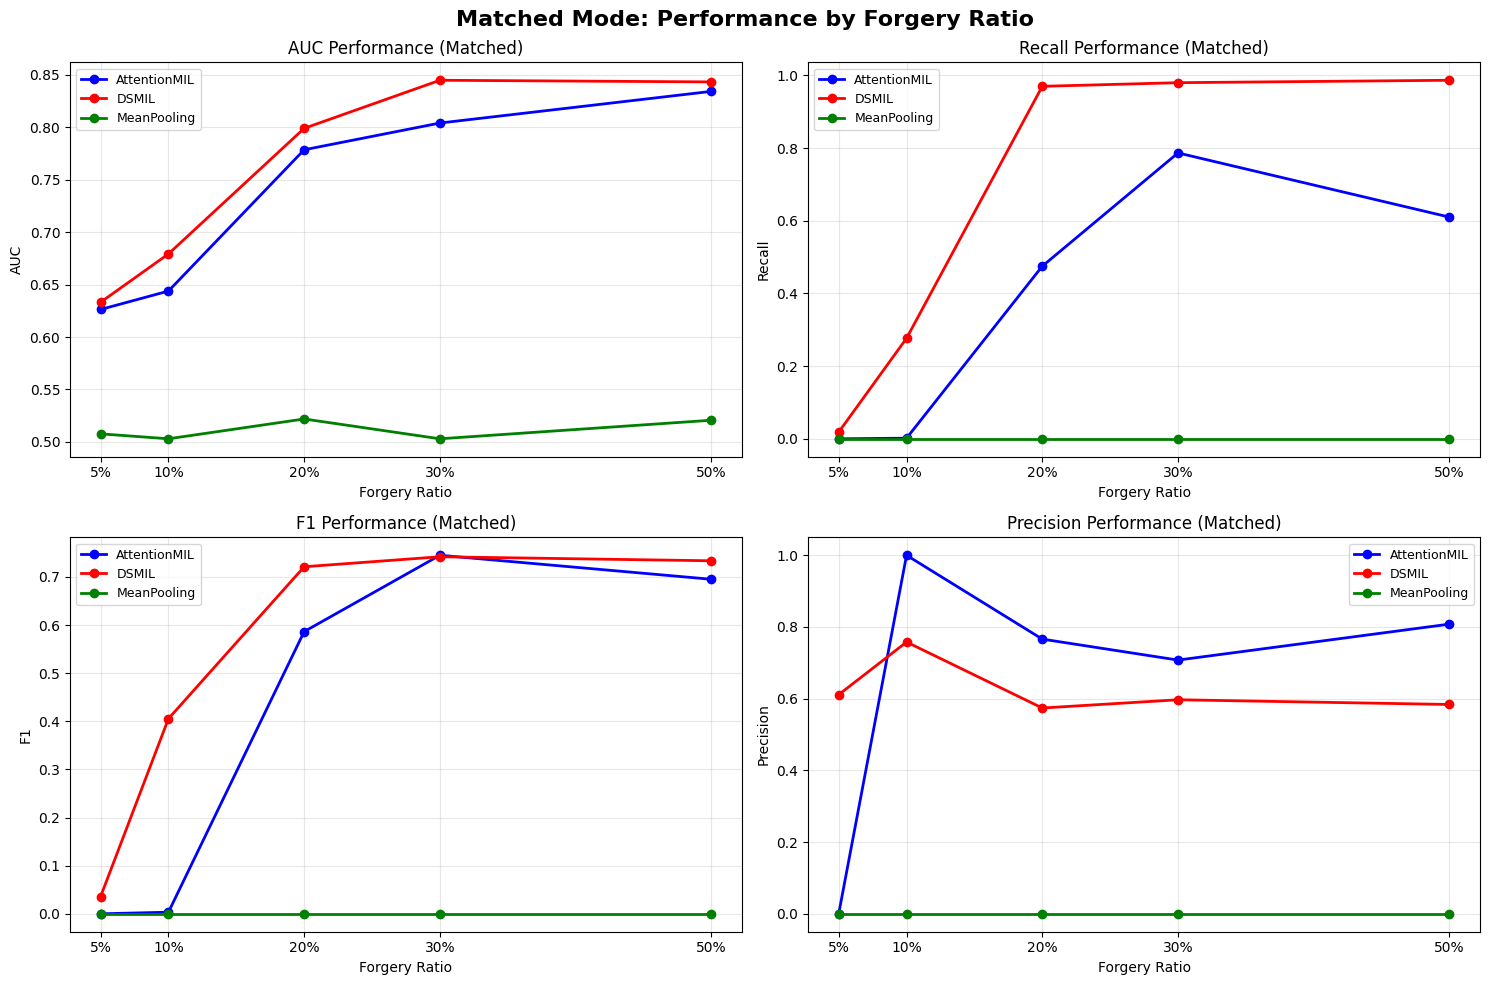

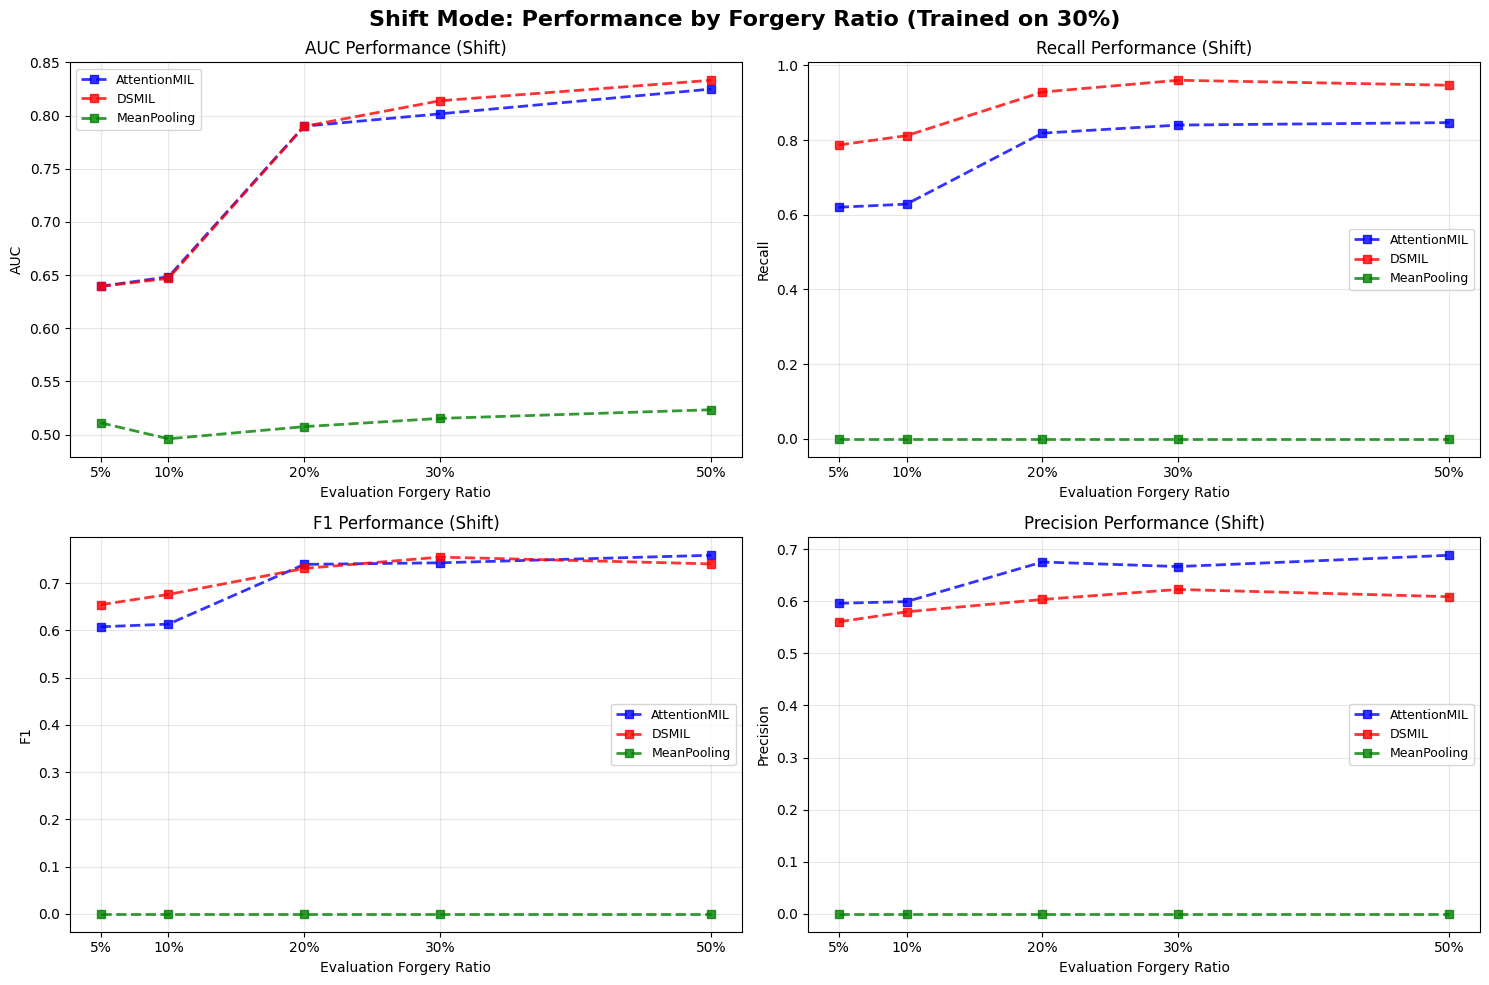

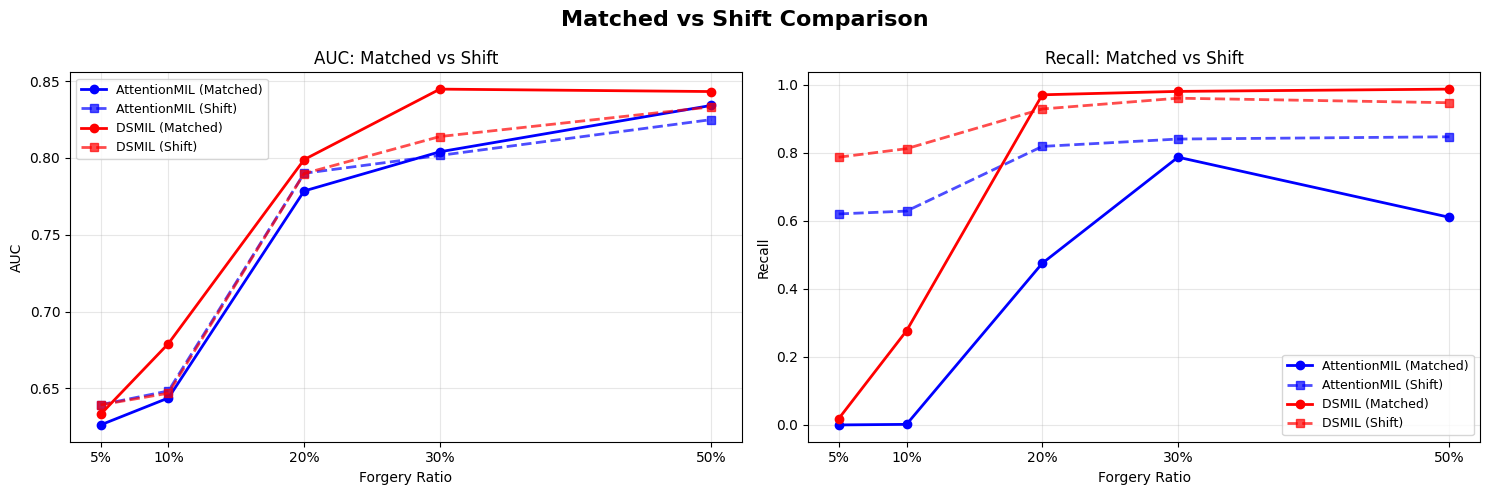


üîç ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù

üìâ ÏÑ±Îä• Ï†ÄÌïò Î∂ÑÏÑù (30% ‚Üí 5%, Matched Î™®Îìú)
--------------------------------------------------
AttentionMIL:
  AUC: 0.804 ‚Üí 0.626 (Œî+0.178)
  Recall: 0.787 ‚Üí 0.000 (Œî+0.787)
DSMIL:
  AUC: 0.845 ‚Üí 0.633 (Œî+0.212)
  Recall: 0.980 ‚Üí 0.018 (Œî+0.962)
MeanPooling:
  AUC: 0.503 ‚Üí 0.508 (Œî-0.005)
  Recall: 0.000 ‚Üí 0.000 (Œî+0.000)

üÜö Matched vs Shift ÎπÑÍµê (5% ÌèâÍ∞Ä Í∏∞Ï§Ä)
--------------------------------------------------
AttentionMIL:
  AUC: Matched=0.626, Shift=0.639 (Œî+0.013)
  Recall: Matched=0.000, Shift=0.620 (Œî+0.620)
DSMIL:
  AUC: Matched=0.633, Shift=0.639 (Œî+0.006)
  Recall: Matched=0.018, Shift=0.787 (Œî+0.768)
MeanPooling:
  AUC: Matched=0.508, Shift=0.511 (Œî+0.003)
  Recall: Matched=0.000, Shift=0.000 (Œî+0.000)

üèÜ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ (5% ÏúÑÏ°∞ ÎπÑÏú® Í∏∞Ï§Ä)
--------------------------------------------------
Matched Î™®Îìú: DSMIL (AUC: 0.633, Recall: 0.018)
Shift Î™®Îìú: AttentionMIL (AUC: 0.639, Recall

In [13]:
# ==============================================================================
# ÏÑ±Îä• ÏãúÍ∞ÅÌôî Î∞è ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù
# ==============================================================================

# 1. Matched Î™®Îìú ÏÑ±Îä• Î≥ÄÌôî ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Matched Mode: Performance by Forgery Ratio', fontsize=16, fontweight='bold')

metrics = ['auc', 'recall', 'f1', 'precision']
metric_names = ['AUC', 'Recall', 'F1', 'Precision']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    # Matched Î™®ÎìúÎßå ÌîåÎ°Ø
    for j, model in enumerate(['AttentionMIL', 'DSMIL', 'MeanPooling']):
        model_data = matched_df[matched_df['model'] == model]
        colors = ['blue', 'red', 'green']
        ax.plot(model_data['ratio'], model_data[metric], 'o-', 
               color=colors[j], label=model, linewidth=2, markersize=6)
    
    ax.set_xlabel('Forgery Ratio')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Performance (Matched)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # xÏ∂ï ÎùºÎ≤®ÏùÑ ÌçºÏÑºÌä∏Î°ú ÌëúÏãú (50% Ìè¨Ìï®)
    ax.set_xticks([0.05, 0.10, 0.20, 0.30, 0.50])
    ax.set_xticklabels(['5%', '10%', '20%', '30%', '50%'])

plt.tight_layout()
plt.show()

# 2. Shift Î™®Îìú ÏÑ±Îä• Î≥ÄÌôî ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Shift Mode: Performance by Forgery Ratio (Trained on 30%)', fontsize=16, fontweight='bold')

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    # Shift Î™®ÎìúÎßå ÌîåÎ°Ø
    for j, model in enumerate(['AttentionMIL', 'DSMIL', 'MeanPooling']):
        model_data = shift_df[shift_df['model'] == model]
        colors = ['blue', 'red', 'green']
        ax.plot(model_data['ratio'], model_data[metric], 's--', 
               color=colors[j], label=model, linewidth=2, markersize=6, alpha=0.8)
    
    ax.set_xlabel('Evaluation Forgery Ratio')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Performance (Shift)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # xÏ∂ï ÎùºÎ≤®ÏùÑ ÌçºÏÑºÌä∏Î°ú ÌëúÏãú (50% Ìè¨Ìï®)
    ax.set_xticks([0.05, 0.10, 0.20, 0.30, 0.50])
    ax.set_xticklabels(['5%', '10%', '20%', '30%', '50%'])

plt.tight_layout()
plt.show()

# 3. Matched vs Shift ÏßÅÏ†ë ÎπÑÍµê (AUCÏôÄ RecallÎßå)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Matched vs Shift Comparison', fontsize=16, fontweight='bold')

comparison_metrics = ['auc', 'recall']
comparison_names = ['AUC', 'Recall']

for i, (metric, metric_name) in enumerate(zip(comparison_metrics, comparison_names)):
    ax = axes[i]
    
    for j, model in enumerate(['AttentionMIL', 'DSMIL']):
        matched_data = matched_df[matched_df['model'] == model]
        shift_data = shift_df[shift_df['model'] == model]
        colors = ['blue', 'red']
        
        ax.plot(matched_data['ratio'], matched_data[metric], 'o-', 
               color=colors[j], label=f'{model} (Matched)', linewidth=2, markersize=6)
        ax.plot(shift_data['ratio'], shift_data[metric], 's--', 
               color=colors[j], label=f'{model} (Shift)', linewidth=2, markersize=6, alpha=0.7)
    
    ax.set_xlabel('Forgery Ratio')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name}: Matched vs Shift')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # xÏ∂ï ÎùºÎ≤®ÏùÑ ÌçºÏÑºÌä∏Î°ú ÌëúÏãú (50% Ìè¨Ìï®)
    ax.set_xticks([0.05, 0.10, 0.20, 0.30, 0.50])
    ax.set_xticklabels(['5%', '10%', '20%', '30%', '50%'])

plt.tight_layout()
plt.show()

# 2. ÎÇÆÏùÄ ÏúÑÏ°∞ ÎπÑÏú®ÏóêÏÑúÏùò ÏÑ±Îä• Ï†ÄÌïò Î∂ÑÏÑù
print("\nüîç ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù")
print("=" * 60)

# 30% vs 5% ÏÑ±Îä• ÎπÑÍµê (Matched Î™®Îìú)
print("\nüìâ ÏÑ±Îä• Ï†ÄÌïò Î∂ÑÏÑù (30% ‚Üí 5%, Matched Î™®Îìú)")
print("-" * 50)
for model in ['AttentionMIL', 'DSMIL', 'MeanPooling']:
    perf_30 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.30)]
    perf_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    
    if not perf_30.empty and not perf_05.empty:
        auc_drop = perf_30['auc'].iloc[0] - perf_05['auc'].iloc[0]
        recall_drop = perf_30['recall'].iloc[0] - perf_05['recall'].iloc[0]
        
        print(f"{model}:")
        print(f"  AUC: {perf_30['auc'].iloc[0]:.3f} ‚Üí {perf_05['auc'].iloc[0]:.3f} (Œî{auc_drop:+.3f})")
        print(f"  Recall: {perf_30['recall'].iloc[0]:.3f} ‚Üí {perf_05['recall'].iloc[0]:.3f} (Œî{recall_drop:+.3f})")

# 3. Matched vs Shift ÎπÑÍµê (5% ÌèâÍ∞Ä Í∏∞Ï§Ä)
print("\nüÜö Matched vs Shift ÎπÑÍµê (5% ÌèâÍ∞Ä Í∏∞Ï§Ä)")
print("-" * 50)
for model in ['AttentionMIL', 'DSMIL', 'MeanPooling']:
    matched_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    shift_05 = shift_df[(shift_df['model'] == model) & (shift_df['ratio'] == 0.05)]
    
    if not matched_05.empty and not shift_05.empty:
        auc_diff = shift_05['auc'].iloc[0] - matched_05['auc'].iloc[0]
        recall_diff = shift_05['recall'].iloc[0] - matched_05['recall'].iloc[0]
        
        print(f"{model}:")
        print(f"  AUC: Matched={matched_05['auc'].iloc[0]:.3f}, Shift={shift_05['auc'].iloc[0]:.3f} (Œî{auc_diff:+.3f})")
        print(f"  Recall: Matched={matched_05['recall'].iloc[0]:.3f}, Shift={shift_05['recall'].iloc[0]:.3f} (Œî{recall_diff:+.3f})")

# 4. ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ Ï∞æÍ∏∞
print("\nüèÜ ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏ (5% ÏúÑÏ°∞ ÎπÑÏú® Í∏∞Ï§Ä)")
print("-" * 50)

# Matched Î™®ÎìúÏóêÏÑú 5% ÏµúÍ≥† ÏÑ±Îä•
matched_05_best = matched_df[matched_df['ratio'] == 0.05].sort_values('auc', ascending=False)
if not matched_05_best.empty:
    best = matched_05_best.iloc[0]
    print(f"Matched Î™®Îìú: {best['model']} (AUC: {best['auc']:.3f}, Recall: {best['recall']:.3f})")

# Shift Î™®ÎìúÏóêÏÑú 5% ÏµúÍ≥† ÏÑ±Îä•
shift_05_best = shift_df[shift_df['ratio'] == 0.05].sort_values('auc', ascending=False)
if not shift_05_best.empty:
    best = shift_05_best.iloc[0]
    print(f"Shift Î™®Îìú: {best['model']} (AUC: {best['auc']:.3f}, Recall: {best['recall']:.3f})")

print("\n‚úÖ ÏãúÍ∞ÅÌôî Î∞è Î∂ÑÏÑù ÏôÑÎ£å!")

In [12]:
# ==============================================================================
# Í≤∞Î°† Î∞è ÌïµÏã¨ Î∞úÍ≤¨ÏÇ¨Ìï≠
# ==============================================================================

print("üìã ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò Í≤∞Î°†")
print("=" * 80)

print("\nüéØ ÌïµÏã¨ Ïó∞Íµ¨ ÏßàÎ¨∏ ÎãµÎ≥Ä:")
print("\n1. ÏúÑÏ°∞ ÎπÑÏú®Ïù¥ ÎÇÆÏïÑÏßàÏàòÎ°ù ÏÑ±Îä•Ïù¥ ÏñºÎßàÎÇò Ï†ÄÌïòÎêòÎäîÍ∞Ä?")

# ÌèâÍ∑† ÏÑ±Îä• Ï†ÄÌïò Í≥ÑÏÇ∞
avg_drops = {}
for model in ['AttentionMIL', 'DSMIL', 'MeanPooling']:
    perf_30 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.30)]
    perf_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    
    if not perf_30.empty and not perf_05.empty:
        auc_drop = (perf_30['auc'].iloc[0] - perf_05['auc'].iloc[0]) / perf_30['auc'].iloc[0] * 100
        recall_drop = (perf_30['recall'].iloc[0] - perf_05['recall'].iloc[0]) / perf_30['recall'].iloc[0] * 100
        avg_drops[model] = {'auc': auc_drop, 'recall': recall_drop}

for model, drops in avg_drops.items():
    print(f"   ‚Ä¢ {model}: AUC {drops['auc']:.1f}% Ï†ÄÌïò, Recall {drops['recall']:.1f}% Ï†ÄÌïò")

print("\n2. Ïñ¥Îñ§ Î™®Îç∏Ïù¥ ÎÇÆÏùÄ ÏúÑÏ°∞ ÎπÑÏú®ÏóêÏÑú Îçî Í∞ïÍ±¥ÌïúÍ∞Ä?")
best_05_models = matched_df[matched_df['ratio'] == 0.05].sort_values(['recall', 'auc'], ascending=False)
print(f"   ‚Ä¢ 5% ÎπÑÏú®ÏóêÏÑú ÏµúÍ≥† ÏÑ±Îä•: {best_05_models.iloc[0]['model']}")
print(f"     Recall: {best_05_models.iloc[0]['recall']:.3f}, AUC: {best_05_models.iloc[0]['auc']:.3f}")

print("\n3. 30% ÌïôÏäµ Î™®Îç∏Ïù¥ 5% ÌÖåÏä§Ìä∏ÏóêÏÑúÎèÑ Ïûò ÎèôÏûëÌïòÎäîÍ∞Ä? (ÎèÑÎ©îÏù∏ Ï†ÅÏùë)")
domain_adaptation_analysis = []
for model in ['AttentionMIL', 'DSMIL', 'MeanPooling']:
    matched_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    shift_05 = shift_df[(shift_df['model'] == model) & (shift_df['ratio'] == 0.05)]
    
    if not matched_05.empty and not shift_05.empty:
        performance_ratio = shift_05['auc'].iloc[0] / matched_05['auc'].iloc[0]
        domain_adaptation_analysis.append((model, performance_ratio))
        status = "Ïö∞Ïàò" if performance_ratio > 0.95 else "Î≥¥ÌÜµ" if performance_ratio > 0.85 else "Ï†ÄÏ°∞"
        print(f"   ‚Ä¢ {model}: {performance_ratio:.2%} ÏÑ±Îä• Ïú†ÏßÄ ({status})")

print("\nüìä Ïã§Ìóò ÏöîÏïΩ:")
print(f"   ‚Ä¢ Ï¥ù {len(RATIOS)}Í∞ú ÏúÑÏ°∞ ÎπÑÏú® ÌÖåÏä§Ìä∏: {[f'{r:.0%}' for r in RATIOS]}")
print(f"   ‚Ä¢ {len(MODEL_CLASSES)}Í∞ú Î™®Îç∏ ÎπÑÍµê: {list(MODEL_CLASSES.keys())}")
print(f"   ‚Ä¢ 2Í∞ÄÏßÄ Ïã§Ìóò Î™®Îìú: Matched (ÎèÖÎ¶Ω ÌïôÏäµ) vs Shift (ÎèÑÎ©îÏù∏ Ï†ÅÏùë)")

# ÏµúÏ¢Ö Í∂åÏû•ÏÇ¨Ìï≠
print("\nüí° Í∂åÏû•ÏÇ¨Ìï≠:")
best_overall = matched_df.groupby('model')['recall'].mean().sort_values(ascending=False)
print(f"   ‚Ä¢ Ï†ÑÎ∞òÏ†Å Í∂åÏû• Î™®Îç∏: {best_overall.index[0]} (ÌèâÍ∑† Recall: {best_overall.iloc[0]:.3f})")
print(f"   ‚Ä¢ ÎÇÆÏùÄ ÏúÑÏ°∞ ÎπÑÏú® Ï†ÑÏö©: {best_05_models.iloc[0]['model']}")

if any(ratio > 0.95 for _, ratio in domain_adaptation_analysis):
    best_adapt_model = max(domain_adaptation_analysis, key=lambda x: x[1])[0]
    print(f"   ‚Ä¢ ÎèÑÎ©îÏù∏ Ï†ÅÏùëÏÑ± Ïö∞Ïàò: {best_adapt_model}")
else:
    print(f"   ‚Ä¢ ÎèÑÎ©îÏù∏ Ï†ÅÏùë: Î™®Îì† Î™®Îç∏ÏóêÏÑú ÏÑ±Îä• Ï†ÄÌïò Í¥ÄÏ∞∞, Matched Î™®Îìú Í∂åÏû•")

print("\nüîö ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò ÏôÑÎ£å")
print("="*80)

üìã ÏúÑÏ°∞ ÎπÑÏú® Ïã§Ìóò Í≤∞Î°†

üéØ ÌïµÏã¨ Ïó∞Íµ¨ ÏßàÎ¨∏ ÎãµÎ≥Ä:

1. ÏúÑÏ°∞ ÎπÑÏú®Ïù¥ ÎÇÆÏïÑÏßàÏàòÎ°ù ÏÑ±Îä•Ïù¥ ÏñºÎßàÎÇò Ï†ÄÌïòÎêòÎäîÍ∞Ä?
   ‚Ä¢ AttentionMIL: AUC 22.1% Ï†ÄÌïò, Recall 100.0% Ï†ÄÌïò
   ‚Ä¢ DSMIL: AUC 25.1% Ï†ÄÌïò, Recall 98.1% Ï†ÄÌïò
   ‚Ä¢ MeanPooling: AUC -0.9% Ï†ÄÌïò, Recall nan% Ï†ÄÌïò

2. Ïñ¥Îñ§ Î™®Îç∏Ïù¥ ÎÇÆÏùÄ ÏúÑÏ°∞ ÎπÑÏú®ÏóêÏÑú Îçî Í∞ïÍ±¥ÌïúÍ∞Ä?
   ‚Ä¢ 5% ÎπÑÏú®ÏóêÏÑú ÏµúÍ≥† ÏÑ±Îä•: DSMIL
     Recall: 0.018, AUC: 0.633

3. 30% ÌïôÏäµ Î™®Îç∏Ïù¥ 5% ÌÖåÏä§Ìä∏ÏóêÏÑúÎèÑ Ïûò ÎèôÏûëÌïòÎäîÍ∞Ä? (ÎèÑÎ©îÏù∏ Ï†ÅÏùë)
   ‚Ä¢ AttentionMIL: 102.10% ÏÑ±Îä• Ïú†ÏßÄ (Ïö∞Ïàò)
   ‚Ä¢ DSMIL: 100.97% ÏÑ±Îä• Ïú†ÏßÄ (Ïö∞Ïàò)
   ‚Ä¢ MeanPooling: 100.66% ÏÑ±Îä• Ïú†ÏßÄ (Ïö∞Ïàò)

üìä Ïã§Ìóò ÏöîÏïΩ:
   ‚Ä¢ Ï¥ù 5Í∞ú ÏúÑÏ°∞ ÎπÑÏú® ÌÖåÏä§Ìä∏: ['5%', '10%', '20%', '30%', '50%']
   ‚Ä¢ 3Í∞ú Î™®Îç∏ ÎπÑÍµê: ['AttentionMIL', 'DSMIL', 'MeanPooling']
   ‚Ä¢ 2Í∞ÄÏßÄ Ïã§Ìóò Î™®Îìú: Matched (ÎèÖÎ¶Ω ÌïôÏäµ) vs Shift (ÎèÑÎ©îÏù∏ Ï†ÅÏùë)

üí° Í∂åÏû•ÏÇ¨Ìï≠:
   ‚Ä¢ Ï†ÑÎ∞òÏ†Å Í∂åÏû• Î™®Îç∏: DSMIL (ÌèâÍ∑† 

/tmp/ipykernel_2006/470691822.py:19: RuntimeWarning: invalid value encountered in double_scalars
  recall_drop = (perf_30['recall'].iloc[0] - perf_05['recall'].iloc[0]) / perf_30['recall'].iloc[0] * 100
